In [2]:
import numpy as np
import random 
from matplotlib import pyplot as plt
import copy

### Rikkido Scoring Rule: stand-alone formulae

In [3]:
# Mathematical function definitions
def compute_vol_ema(bets, m: int, prev_EMA = None):
    ''' 
    bets: list of all bets registered so far in market maker
    m: to compute m-day EMA
    prev_EMA: only use once len(bets) > m (so calculating proper EMA) 
    
    EMA formula: EMA_i = (V - EMA_{i-1})*c + EMA_{i-1}, where c = 2 / (m + 1)
    Return: EMA_m if len(bets) ≥ m, SMA_len(bets) otherwise
    '''
    if len(bets) <= m: # returns how many ever days it can average so far
        return np.mean(bets)
    else: 
        return (bets[-1] - prev_EMA)*(2/(m+1)) + prev_EMA
    
def func_z(r, scale = 0.1, n=1, slope_const = 3):
    ''' 
    SCALE, SLOPE_CONST: hyperparameters to fine_tune Rikkido effects
    if want func_z(r) to be 0 at r = 1, keep n=1
    formula: scale*(r-n) / sqrt(slop_const + (r-n)^2)
    for n = 1, slope_const = 3: most negative will be scale*1/2, so generally set scale = alpha 
    '''
    return scale*(r-n)/ (np.sqrt(slope_const + (r-n)**2)) # sigmoid function 

def compute_alpha(bets, vig: int, n: int, t: int, tk: int, prev_EMA_t=None, prev_EMA_tk=None):
    '''
    for alpha = f + z(r)
      n: number of items in market (n=2 assumed in most places in code)
      vig: used to define f = vig/(n log n)
      t; tk = t+k: the windows for EMA calculation
      prev_EMA: value will only get used once len(bets) > m (so calculating proper EMA)
    '''
    f = vig / (n*np.log(n)) # equal to alpha in the standard LS-LMSR
    r = compute_vol_ema(bets, t, prev_EMA_t)/compute_vol_ema(bets, tk, prev_EMA_tk) 
    print("r value:", r)
    return f + func_z(r, scale=f) # z(r) 

In [4]:
bets = np.arange(1, 40, 2)
zeros = np.zeros(10)
bets = np.concatenate((bets, zeros))
vig = 0.02
n = 2
t = 3
tk = 5

incr_bets = []

print('f value:', vig/(n*np.log(n)))

# these will need to be stored in some global variable
prev_EMA_t = None 
prev_EMA_tk = None 

for bet in bets:
    incr_bets.append(bet)
    alpha = compute_alpha(incr_bets, vig, n, t, tk, prev_EMA_t, prev_EMA_tk)
    print("alpha", alpha)
    prev_EMA_t = compute_vol_ema(incr_bets, t, prev_EMA_t)
    prev_EMA_tk = compute_vol_ema(incr_bets, tk, prev_EMA_tk)

f value: 0.014426950408889635
r value: 1.0
alpha 0.014426950408889635
r value: 1.0
alpha 0.014426950408889635
r value: 1.0
alpha 0.014426950408889635
r value: 1.25
alpha 0.0164879433244453
r value: 1.4
alpha 0.01767326787934993
r value: 1.2857142857142858
alpha 0.016775047556493283
r value: 1.2222222222222223
alpha 0.016262880153166365
r value: 1.1818181818181819
alpha 0.01593311177147412
r value: 1.1538461538461537
alpha 0.015703371831671576
r value: 1.1333333333333333
alpha 0.015534261493720568
r value: 1.1176470588235294
alpha 0.015404627540929978
r value: 1.105263157894737
alpha 0.015302115049676799
r value: 1.0952380952380953
alpha 0.015219030455731213
r value: 1.0869565217391304
alpha 0.015150335318511347
r value: 1.08
alpha 0.015092593064502932
r value: 1.0740740740740742
alpha 0.015043379811793281
r value: 1.0689655172413792
alpha 0.01500093722030292
r value: 1.064516129032258
alpha 0.014963958887530064
r value: 1.0606060606060606
alpha 0.014931454000717886
r value: 1.057142857

### BettingMarket class

In [5]:
class BettingMarket: 
    '''
    Notes on BettingMarket assumptions and preconditions:
    - Only supports markets/rules that "move forward in obligation space" (as LS-LMSR requires)
       i.e. assumes traders interacting with market can only do "buy" orders (but note effect of buying item 2 ~= effect of selling item 1)
    '''
    def __init__(self, n, init_quant, msr_type, alpha, beta, true_dist, **kwargs):
        self.n = n
        self.q = init_quant # a list of length n
        self.msr = msr_type # a string representing type market scoring rule
        if self.msr == "Rikkido":
            self.set_rikkido_params(t=kwargs['t'], tk=kwargs['tk'], scale=(kwargs['scale'] if 'scale' in kwargs else None), slope_const=(kwargs['slope_const'] if 'slope_const' in kwargs else None))
        self.alpha = alpha  # the constant alpha for LS-LMSR
        self.beta = beta    # the constant beta for LMSR
        
        self.true_dist = true_dist # a "ground truth" probability distribution from which to draw the result 
        self.outcome = None 

        self.traders = []
        self.init_q = init_quant 
        self.init_cost = self.cost(self.q)
        # self.revenue = -self.init_cost
     
    def set_rikkido_params(self, t: int, tk: int, scale=None, slope_const=None):
        self.t = t     # numerator window for EMA calculation
        self.tk = tk   # denominator window for EMA calculation
        self.scale = scale
        self.slope_const = slope_const
        self.prev_ema_t = None 
        self.prev_ema_tk = None
        self.bets = [] # list of tuples: [trader_id, total_bet_amt] -- where adjacent tuples should have diff trader_id 
        

    def cost_LMSR(self, beta, q):
        return beta*np.log(np.sum(np.exp(np.array(q)/beta)))
    # TBD: DEAL WITH OVERFLOW IN EXP

    def cost(self, q):
        if self.msr == "LMSR":
            return self.cost_LMSR(self.beta, q)
        elif self.msr=="LSLMSR": 
            b = self.alpha*np.sum(q)
            return self.cost_LMSR(b, q)
        else: # "Rikkido": Rikkido scoring rule
            b = self.compute_rikkido_alpha()*np.sum(q) 
            return self.cost_LMSR(b, q)

    def get_price_vector(self, q):
        return [self.get_price(i, q) for i in range(len(q))]

    def get_price_prob(self, q):
        price_vec = self.get_price_vector(q)
        return np.array(price_vec)/np.sum(price_vec)
    
    def get_price(self, i, q):
        if self.msr == "LMSR":
            return np.exp(q[i]/self.beta)/np.sum(np.exp(np.array(q)/self.beta))
        elif self.msr == "LSLMSR": 
            b = self.alpha*sum(q)
            sum_term = np.sum(np.exp(np.array(q)/b))
            term1 = self.alpha * np.log(sum_term)
            term2_num = (np.sum(q)*np.exp(q[i]/b) - np.sum([x*np.exp(x/b) for x in q]))
            term2_denom = np.sum(q)*sum_term
            return term1 + term2_num/term2_denom
        else: # Rikkido: do analytically (approximation)
            dx = 1e-6
            q_upd = copy.deepcopy(self.q)
            q_upd[i]+=dx
            return (self.cost(q_upd)-self.cost(self.q))/dx

    def submit_bet(self, trader, delta, verbose=False):
        if self.msr == "Rikkido":
            ## FOR RIKKIDO 
            if len(self.bets)==0 or trader.id != self.bets[-1][0]: 
                if len(self.bets) > 0: # update moving averages (most recent trader has completed trading)
                    self.update_vol_ema(self.t)
                    self.update_vol_ema(self.tk)
                self.bets.append([trader.id, np.sum(delta)])
            else: # last registered trade was made by this trader
                self.bets[-1][1] += np.sum(delta)
            ##############
        new_q = [sum(x) for x in zip(self.q, delta)]
        curr_cost = self.cost(self.q)
        new_cost = self.cost(new_q)
        if(new_cost-curr_cost > trader.money):
            if verbose:
                print("Insufficient trader funds: trader money={m}, transaction cost={c}".format(m=trader.money, c=new_cost-curr_cost))
            return None
        self.q = new_q
        trader.money -= (new_cost-curr_cost)
        trader.payouts = [sum(x) for x in zip(trader.payouts, delta)]
        if verbose:
            print("Trader", trader.id, "updates to", self.q, "for cost of", (new_cost-curr_cost))
        return new_cost - curr_cost
    
    def get_revenue(self, outcome):
        # NOTE: Revenue function: current definition is C(q)-C(q0)-z_i, where z_i is the PAYOUT for the outcome i (not total quantity_i)
        #  (as this seems to match the numerical values used in Othman et al.)
        return self.cost(self.q)-self.init_cost-(self.q[outcome]-self.init_q[outcome])
        # return self.cost(self.q)-self.init_cost-self.q[outcome]
    
    def get_expected_revenue(self):
        revs = [self.get_revenue(i) for i in range(len(self.q))]
        return np.dot(self.get_price_prob(self.q), np.array(revs))
    
    def get_market_state(self, silence=False):
        if self.outcome is None: # draw the outcome the first time this is called
            self.outcome = random.choices(list(range(self.n)), weights=self.true_dist)[0]
        
        revenue = self.get_revenue(self.outcome)
        if not silence:
            print("State:", self.q)
            print("Final instantaneous prices:", [self.get_price(0, self.q), self.get_price(1, self.q)])
            print("Outcome realized:", self.outcome)
            print("Revenue:", revenue)
    
    
    ### RIKKIDO FUNCTIONS ### 
    def update_vol_ema(self, m: int):
        ''' 
        Parameters:
          - m: to compute m-day EMA (should be either self.t or self.tk)
        Notes:
          - Recall self.bets is a list of [trader_id, bet_amt]: so need to use self.bets[-1][1] for volume
          - EMA formula: EMA_i = (V - EMA_{i-1})*c + EMA_{i-1}, where c = 2 / (m + 1)
          - Updates corresponding self.ema_m to EMA_m if len(bets) > m, SMA_len(bets) otherwise
        '''
        assert len(self.bets) > 0    
        if len(self.bets) <= m: # returns how many ever days it can average so far
            if m == self.tk:
                self.prev_ema_tk = np.mean(self.bets)
            if m == self.t:
                self.prev_ema_t = np.mean(self.bets)
        else: 
            if m == self.tk:
                self.prev_ema_tk = (self.bets[-1][1] - self.prev_ema_tk)*(2/(m+1)) + self.prev_ema_tk
            else:
                self.prev_ema_t = (self.bets[-1][1] - self.prev_ema_t)*(2/(m+1)) + self.prev_ema_t
            
    def func_z(r, scale = 0.1, n=1, slope_const = 3):
        ''' 
        Notes:
        - SCALE, SLOPE_CONST: hyperparameters to fine_tune Rikkido effects
        - if want func_z(r) to be 0 at r = 1, keep n=1
        - formula: scale*(r-n) / sqrt(slop_const + (r-n)^2)
        - for n = 1, slope_const = 3: most negative will be scale*1/2, so generally set scale = alpha 
        '''
        return scale*(r-n)/ (np.sqrt(slope_const + (r-n)**2)) # sigmoid function 
    
    def compute_rikkido_alpha(self):
        '''
        Compute alpha = f + z(r)
        '''
#         f = vig / (self.n*np.log(self.n)) # equal to alpha in the standard LS-LMSR
        f = self.alpha 
        r = (self.prev_ema_t/self.prev_ema_tk if self.prev_ema_t is not None else 1)
#         print("r value:", r)
        
        slope_const = (self.slope_const if self.slope_const is not None else 3)
        scale = (self.scale if self.scale is not None else f)
        return f + func_z(r, scale=scale, n=1, slope_const=slope_const) # z(r) 
#         self.prev_ema_t = compute_vol_ema(bets, t, self.prev_ema_t) # ISSUE: CAN'T UPDATE THIS EVERY TIME COST CALLED -- need to just do once per bet
#         self.prev_ema_tk = compute_vol_ema(bets, tk, self.prev_ema_tk)
        

# TBD: IMPLEMENT "MOVE FORWARD IN OBLIGATION SPACE" requirement

### Trader class

In [6]:
class Trader:
    def __init__(self, id, n, init_money):
        self.n = n
        self.id = id
        self.money = init_money
        self.payouts = [0]*n
    
    def set_belief(self, prob_vector):
        self.belief = prob_vector
    
    def bet(self, mkt: BettingMarket, i, amt, verbose=False):
        delta = [(1 if i==j else 0)*amt for j in range(self.n)]
        return mkt.submit_bet(self, delta, verbose)

    def play(self, mkt: BettingMarket, DELTA_FRAC=0.002, MAX_ITER=2/0.002, verbose=False):
        '''
         Makes bet for this Trader's turn by buying each asset while its price is less than probability distribution belief
           if Trader can afford the bet
         DELTA_FRAC: fraction of market to buy in each evaluation (in each delta/step) of price vs belief -- sets discretizing error
         MAX_ITER: sets maximum number of times for evaluating the price/probability and betting DELTA_FRAC of market
        '''
        # Q: could this infinite loop? do we really need MAX_ITER or not? 
        flag=True
        init_cost = mkt.cost(mkt.q)
        init_payouts = self.payouts

        bet_cost = True
        if(mkt.get_price(0, mkt.q) < self.belief[0]):
            while(MAX_ITER >= 0 and mkt.get_price(0, mkt.q) < self.belief[0] and bet_cost is not None):
                bet_cost = self.bet(mkt, 0, DELTA_FRAC*mkt.q[0])
                MAX_ITER-=1
        elif(mkt.get_price(1, mkt.q) < self.belief[1]):   
            while(MAX_ITER >= 0 and mkt.get_price(1, mkt.q) < self.belief[1] and bet_cost is not None):
                bet_cost = self.bet(mkt, 1, DELTA_FRAC*mkt.q[1])
                MAX_ITER-=1

        if(MAX_ITER < 0):
            print("LOG: play() function hit MAX_ITER")
        
        final_cost = mkt.cost(mkt.q)
        if(verbose):
            print("Cost of transaction:", final_cost-init_cost)
            print("Expected final return after transaction:", sum(self.belief[i]*self.payouts[i] for i in range(self.n)))
            print("Current price vs beliefs:", [mkt.get_price(0, mkt.q), mkt.get_price(1, mkt.q)], self.belief)

        bet = [x[0]-x[1] for x in zip(self.payouts, init_payouts)]
        return bet, final_cost-init_cost

### Simulation class

In [7]:
class Simulation:

    def __init__(self):
        self.betters = []
    
    # def add_better(self, trader: Trader):
    #     self.betters.append(trader)

    def draw_unif_ground_truth(self, low, high):
        p0 = low+(high-low)*random.random()
        return [p0, 1-p0]

    def create_market_comp(self, init_quant, msr1, msr2, msr1_const, msr2_const, ground_truth):
        b1 = BettingMarket(2, init_quant, msr1, (None if msr1 == "LMSR" else msr1_const), (None if msr1 == "LS-LMSR" else msr1_const), ground_truth)
        b2 = BettingMarket(2, init_quant, msr2, (None if msr2 == "LMSR" else msr2_const), (None if msr2 == "LS-LMSR" else msr2_const), ground_truth)
        return [b1, b2]

    def compute_b(self, alpha, init_quant):
        lslmsr =  BettingMarket(2, init_quant, "LSLMSR", alpha, None, [-1, -1])
        worst_case_loss = lslmsr.init_cost # worst-case LS-LMSR loss is just C(q0)
        # worst-case LMSR loss is -b ln (exp(q0_i /b) / sum(exp(q0_j / b))), where q0_i is the max value in init_quant
        #   (this formula reduces to b ln(n) for uniform initial distribution; TBD: check that correct for general case)
        uniform_flag = True
        for x in init_quant:
            if not x == init_quant[0]:
                uniform_flag = False
                break
        assert(uniform_flag)
        b = worst_case_loss / np.log(2)
        return b, worst_case_loss
    
    ### to include handling of Rikkido ## 
    def simple_noise_sim_gen(self, ntraders, trader_money, markets, priv_info_noise=0.2, look_back = 50, k=0.5, k_min=None, k_max=None, silence=False, verbose=False):
        for m in markets[1:]:
            assert m.true_dist == markets[0].true_dist
        if not silence:
            print('\n\nGROUND TRUTH:', markets[0].true_dist)
            print('priv_info_noise:', priv_info_noise, '; look_back:', look_back, '; k:', k)
            print('INITIAL PRICES', [m.get_price_vector(m.q) for m in markets])
            
        traders = [] # (ntraders x len(markets))
        bets = [] # (ntraders x len(markets))
        costs = [] # (ntraders x len(markets))
        prev_market_p0 = [[] for i in range(len(markets))]

        for i in range(ntraders):
            traders.append([])
            bets.append([])
            costs.append([])
            
            priv_info = min(random.random()*(2*priv_info_noise)+max(markets[0].true_dist[0]-priv_info_noise, 0.001), 0.999)
            trad_p0 = priv_info
            
            for im in range(len(markets)):
                prev_market_p0[im].append(markets[im].get_price_prob(markets[im].q)[0])
                trader = Trader(i, 2, trader_money)
                lookback_avg = np.mean(prev_market_p0[im][-1*min(look_back, i+1):])
                k = ((k_max+(k_min-k_max)*(i+1)/ntraders) if k_min is not None else k)
                trad_p0 = k*trad_p0 + (1-k)*lookback_avg
                trader.set_belief([trad_p0, 1-trad_p0])
                traders[-1].append(trader)
                if not silence:
                    print(markets[im].msr, "trader", i, ":")
                bet, cost = trader.play(markets[im], verbose=verbose)
                bets[-1].append(bet)
                costs[-1].append(cost)
                if not silence:
                    print("Final: bet:", bet, "cost:", cost)
                    print('------')
            
        if not silence:
            print('==========')
        
        prices = []
        exprevs = []
        for m in markets:
            if not silence:
                print('\n',m.msr,"market:")
            m.get_market_state(silence=silence)
            prices.append(m.get_price_prob(m.q))
            exprevs.append(m.get_expected_revenue())
        return prices, exprevs
    
    def simple_noise_sim(self, ntraders, trader_money, markets, priv_info_noise=0.2, look_back = 50, k=0.5, k_min=None, k_max=None, silence=False, verbose=False):
        '''
        Idea: at each time instant (for each trader), 
          (1) draw some (noisy) private info
          (2) use average of last look_back market prices 
          (3) trader belief is a weighted average (weighted by k) of market average and private info 
        Parameters:
         - priv_info_noise: private info will be uniform in [ground_truth-priv_info_noise, ground_truth+priv_info_noise]
             (Note: for intended simulation, this should be pretty noisy!)
         - look_back: number of previous market price beliefs to consider 
         - k: weight for weighted average belief (OR: k_min --> k_max)
        '''
        b1, b2 = markets[0], markets[1]
        assert(b1.true_dist == b2.true_dist)
       
        if not silence:
            print('\n\nGROUND TRUTH:', b1.true_dist)
            print('priv_info_noise:', priv_info_noise, '; look_back:', look_back, '; k:', k)
            print('INITIAL PRICE: LMSR', [b1.get_price_vector(b1.q)])
            print('INITIAL PRICE: LS-LMSR', [b2.get_price_vector(b2.q)], '\n')
        
        traders_b1 = []
        bets_b1 = []
        costs_b1 = []
        traders_b2 = []
        bets_b2 = []
        costs_b2 = []
        prev_b1market_p0 = []
        prev_b2market_p0 = []

        for i in range(ntraders):
            traderv1 = Trader(i, 2, trader_money)
            traders_b1.append(traderv1)
            traderv2 = Trader(i, 2, trader_money)
            traders_b2.append(traderv2)

            prev_b1market_p0.append(b1.get_price_prob(b1.q)[0])
            prev_b2market_p0.append(b2.get_price_prob(b2.q)[0])

            # MAIN: Set this trader i's belief: lambda*(priv_info) + (1-lambda)*(market_avg_till_now, up to look_back)
            # 1. some private info distributed noisily around ground truth (want this to be pretty noisy?)
            #  [TBD: determine what distribution should private info be drawn from]
            priv_info = min(random.random()*(2*priv_info_noise)+max(b1.true_dist[0]-priv_info_noise, 0.001), 0.999)
            trad_b1_p0, trad_b2_p0 = priv_info, priv_info
            # 2. compute average of look_back previous market values
            b1avg, b2avg  = np.mean(prev_b1market_p0[-1*min(look_back, i+1):]), np.mean(prev_b2market_p0[-1*min(look_back, i+1):])
            # 3. weight previous market prob values with private info based on k: k*(MY INFO)+(1-k)*(MARKET AVG)
            #      with possibility for using a k linearly varying from **k_max to k_min** (NOTE DIRECTION!) across ntraders
            #       e.g. 1st trader uses k=k_max=0.8 (rely on private info), final trader uses k=k_min=0.2 (rely on market avg)
            k = ((k_max+(k_min-k_max)*(i+1)/ntraders) if k_min is not None else k)
            # note: variable k does NOT seem to work great for increasing accuracy trend -- does lead to BETTER MM revenue? somehow?
            trad_b1_p0 = k*trad_b1_p0 + (1-k)*b1avg
            trad_b2_p0 = k*trad_b2_p0 + (1-k)*b2avg 

            traderv1.set_belief([trad_b1_p0, 1-trad_b1_p0])
            traderv2.set_belief([trad_b2_p0, 1-trad_b2_p0])
            if not silence:
                print("LMSR market trader", i, ":")
            bet1, cost1 = traderv1.play(b1, verbose=verbose)
            bets_b1.append(bet1)
            costs_b1.append(cost1)
            if not silence:
                print("Final: bet:", bet1, "cost:", cost1)
                print('------')

                print("LS-LMSR market trader", i, ":")
            bet2, cost2 = traderv2.play(b2, verbose=verbose)
            bets_b2.append(bet2)
            costs_b2.append(cost2)
            if not silence:
                print("Final: bet:", bet2, "cost:", cost2)
                print()
        if not silence:
            print('==========')
            print('LMSR market: ')
        b1.get_market_state(silence=silence)
        if not silence:
            print()
            print('LS-LMSR market')
        b2.get_market_state(silence=silence)

        return (b1.get_price_prob(b1.q), b2.get_price_prob(b2.q), b1.get_expected_revenue(), b2.get_expected_revenue(), b1.get_revenue(b1.outcome), b2.get_revenue(b2.outcome), b1.outcome, b2.outcome)
    
    
    def perfect_trader_sim(self, ntraders, trader_money, markets, silence=False, verbose=False):
        b1, b2 = markets[0], markets[1]
        assert(b1.true_dist == b2.true_dist)
       
        if not silence:
            print('\n\nGROUND TRUTH:', b1.true_dist)
            print('INITIAL PRICE: LMSR', [b1.get_price_vector(b1.q)])
            print('INITIAL PRICE: LS-LMSR', [b2.get_price_vector(b2.q)], '\n')

        traders_b1 = []
        bets_b1 = []
        costs_b1 = []
        traders_b2 = []
        bets_b2 = []
        costs_b2 = []

        for i in range(ntraders):
            traderv1 = Trader(i, 2, trader_money)
            traderv1.set_belief(b1.true_dist)
            traders_b1.append(traderv1)
            traderv2 = Trader(i, 2, trader_money)
            traderv2.set_belief(b1.true_dist)
            traders_b2.append(traderv2)
            
            if not silence:
                print("LMSR market trader", i, ":")
            bet1, cost1 = traderv1.play(b1, verbose=verbose)
            bets_b1.append(bet1)
            costs_b1.append(cost1)
            if not silence:
                print("Final: bet:", bet1, "cost:", cost1)
                print('------')

                print("LS-LMSR market trader", i, ":")
            bet2, cost2 = traderv2.play(b2, verbose=verbose)
            bets_b2.append(bet2)
            costs_b2.append(cost2)
            if not silence:
                print("Final: bet:", bet2, "cost:", cost2)
                print()
        if not silence:
            print('==========')
            print('LMSR market: ')
        b1.get_market_state(silence=silence)
        if not silence:
            print('\n LS-LMSR market')
        b2.get_market_state(silence=silence)
        return (b1.get_price_vector(b1.q), b2.get_price_vector(b2.q), b1.get_revenue(b1.outcome), b2.get_revenue(b2.outcome)) # change this to same outcome?
    


### Rikkido: investigations

Run simple simulation with Rikkido

In [8]:
# Run simple simulation with Rikkido
s = Simulation()
ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
init_quant = [100, 100]
alpha = 0.03
b, worst_case_loss = s.compute_b(alpha, init_quant)
b_lmsr = BettingMarket(2, init_quant, "LMSR", None, b, [0.8, 0.2])
b_ls = BettingMarket(2, init_quant, "LSLMSR", alpha, None, [0.8, 0.2])
b_r = BettingMarket(2, init_quant, "Rikkido", alpha, None, [0.8, 0.2], t=2, tk=4)
mkts = [b_lmsr, b_ls, b_r]


prices, exprevs = s.simple_noise_sim_gen(30, 10000000, mkts, verbose=True)

print("Price probabilities:", prices)
print("Expected revenues:", exprevs)



GROUND TRUTH: [0.8, 0.2]
priv_info_noise: 0.2 ; look_back: 50 ; k: 0.5
INITIAL PRICES [[0.5, 0.5], [0.5207944154167984, 0.5207944154167984], [0.5207944440144274, 0.5207944440144274]]
LMSR trader 0 :
Cost of transaction: 44.9935328865125
Expected final return after transaction: 50.07546134312672
Current price vs beliefs: [0.6293755904354894, 0.3706244095645106] [0.629297685616736, 0.37070231438326395]
Final: bet: [79.57356667226709, 0.0] cost: 44.9935328865125
------
LSLMSR trader 0 :
Cost of transaction: 0.6581563742925169
Expected final return after transaction: 0.680975552370794
Current price vs beliefs: [0.5704294292733234, 0.470861494980441] [0.564648842808368, 0.435351157191632]
Final: bet: [1.2060160240192066, 0.0] cost: 0.6581563742925169
------
Rikkido trader 0 :
Cost of transaction: 0.21185879807227082
Expected final return after transaction: 0.2131426983302353
Current price vs beliefs: [0.5374216556219835, 0.5041339505851283] [0.532324421404184, 0.467675578595816]
Final: be

Compute results while varying alpha (WITH RIKKIDO)

In [9]:
vigs = np.arange(0.02, 0.4, 0.02)
alphas = vigs/(2*np.log(2))

# N_TRADERS = 20
N_TRADERS = 50
init_quant = [100, 100]
N_TRIALS = 40
LOOK_BACK = int(N_TRADERS/4)
K = 0.3
K_MIN = 0.2
K_MAX = 0.6
# PRIV_NOISE = 0.2
PRIV_NOISE = 0.3

num_markets = 3
acc = [[] for i in range(num_markets)]
acc_quartiles = [[] for i in range(num_markets)]
exprev = [[] for i in range(num_markets)]
exprev_quartiles = [[] for i in range(num_markets)]
wcls= [] # worst-case losses 

for alpha in alphas:
    s = Simulation()
    acc_temp = [[] for i in range(num_markets)]
    exprev_temp = [[] for i in range(num_markets)]
    b, worst_case_loss = s.compute_b(alpha, init_quant)
    # print(b, worst_case_loss)
    wcls.append(-worst_case_loss)

    for _ in range(N_TRIALS):
        #### SET HYPERPARAMETER
        ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
        #### 
        b, worst_case_loss = s.compute_b(alpha, init_quant)
        b_lmsr = BettingMarket(2, init_quant, "LMSR", None, b, ground_truth)
        b_ls = BettingMarket(2, init_quant, "LSLMSR", alpha, None, ground_truth)
        b_r = BettingMarket(2, init_quant, "Rikkido", alpha, None, ground_truth, t=2, tk=4, slope_const = 1)
        mkts = [b_lmsr, b_ls, b_r]
        prices, exprevs = s.simple_noise_sim_gen(N_TRADERS, 10000000, mkts, priv_info_noise=PRIV_NOISE,look_back=LOOK_BACK, k_min=K_MIN, k_max=K_MAX, silence=True, verbose=False)
        
        for j in range(num_markets):
            acc_temp[j].append(1-abs(prices[j][0]-ground_truth[0]))
            exprev_temp[j].append(exprevs[j])
        
    for i in range(num_markets):
        acc[i].append(np.median(acc_temp[i]))
#         print(alpha, i, acc[i])
        exprev[i].append(np.median(exprev_temp[i]))
        acc_quartiles[i].append([acc[i][-1]-np.quantile(acc_temp[i], 0.25), np.quantile(acc_temp[i], 0.75)-acc[i][-1]])
        exprev_quartiles[i].append([exprev[i][-1]-np.quantile(exprev_temp[i], 0.25), np.quantile(exprev_temp[i], 0.75)-exprev[i][-1]])
    
for i in range(num_markets):
    exprev_quartiles[i] = [[exprev_quartiles[i][j][0] for j in range(len(alphas))], [exprev_quartiles[i][j][1] for j in range(len(alphas))]]
    acc_quartiles[i] = [[acc_quartiles[i][j][0] for j in range(len(alphas))], [acc_quartiles[i][j][1] for j in range(len(alphas))]]


Plot results

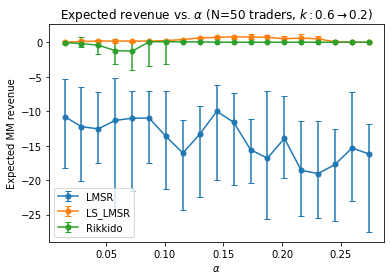

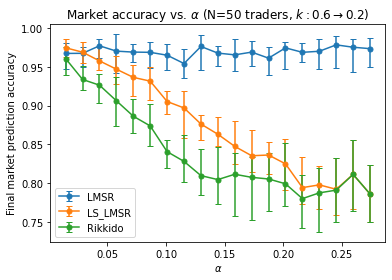

In [10]:
## Plot results

## A. EXP REV vs ALPHA 
# plt.errorbar(alphas, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.errorbar(alphas, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
## note: this plots MEDIANS and 1st / 3rd quartile
plt.errorbar(alphas, exprev[0], yerr=exprev_quartiles[0], marker='o',markersize=5, capsize=3, label='LMSR')
plt.errorbar(alphas, exprev[1], yerr=exprev_quartiles[1], marker='o',markersize=5, capsize=3, label='LS_LMSR')
plt.errorbar(alphas, exprev[2], yerr=exprev_quartiles[2], marker='o',markersize=5, capsize=3, label='Rikkido')

# plt.plot(alphas, wcls, marker='o',markersize=5, label='worst-case-losses')
plt.ylabel('Expected MM revenue')
plt.title(r'Expected revenue vs. $\alpha$ (N=50 traders, $k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'$\alpha$')
plt.legend()
# plt.savefig('figs/simple_noise_exprev_alpha.png')
plt.show()

## B. ACCURACY vs ALPHA 
# plt.plot(alphas, acc_LS, marker='o',label='LS_LMSR')
# plt.plot(alphas, acc_LMSR, marker='o', label='LMSR')
## note: this plots MEDIANS and 1st / 3rd quartile
plt.errorbar(alphas, acc[0], yerr=acc_quartiles[0], marker='o',markersize=5, capsize=3, label='LMSR')
plt.errorbar(alphas, acc[1], yerr=acc_quartiles[1], marker='o',markersize=5, capsize=3, label='LS_LMSR')
plt.errorbar(alphas, acc[2], yerr=acc_quartiles[2], marker='o',markersize=5, capsize=3, label='Rikkido')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'Final market prediction accuracy')
plt.title(r'Market accuracy vs. $\alpha$ (N=50 traders, $k: 0.6 \rightarrow 0.2$)')
plt.legend()
# plt.savefig('figs/simple_noise_acc_alpha.png')
plt.show()

## C. EXP REV vs ACCURACY (deprecated -- see Janum's code for plotting this instead)
# plt.plot(acc_LS, wcls, marker='o',markersize=5, label='worst-case-losses')
# plt.errorbar(acc_LMSR, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.errorbar(acc_LS, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
# plt.ylabel('Expected MM revenue')
# plt.title(r'Expected revenue vs. price accuracy (N=20 traders in noise model)')
# plt.xlabel(r'Price accuracy')
# plt.legend()
# # plt.savefig('figs/noise2_exprev_accuracy.png')
# plt.show()

### Perfect information: run various simulations (different parameters) 

In [11]:
vigs = np.arange(0.02, 0.2, 0.01)
alphas = vigs/(2*np.log(2))

init_quant = [100, 100]
N_TRIALS = 100
N_TRADERS = 10

acc_LS = []
acc_LMSR = []
rev_LS = []
rev_LMSR = []
rev_stdevs_LMSR = []
rev_stdevs_LS = []

exprev_LMSR = []
exprev_LS = []
exprev_stdevs_LMSR = []
exprev_stdevs_LS = []

wcls= []

for alpha in alphas:
    s = Simulation()
    acc_LS_temp = []
    acc_LMSR_temp = []
    rev_LS_temp = []
    rev_LMSR_temp = []
    exprev_LMSR_temp = []
    exprev_LS_temp = []

    b, worst_case_loss = s.compute_b(alpha, init_quant)
    # print(b, worst_case_loss)
    wcls.append(-worst_case_loss)

    for i in range(N_TRIALS):
        ground_truth = s.draw_unif_ground_truth(0.7, 0.9)
        markets = s.create_market_comp([100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_price, b2_price, b1_rev, b2_rev = s.perfect_trader_sim(N_TRADERS, 100000000, markets, silence=True)
        # print(b1.init_cost, b1.cost(b1.q), b1.q[b1.outcome], worst_case_loss)

        # normalize prices (specifically for b2)
        b1_price = np.array(b1_price)/np.sum(b1_price)
        b2_price = np.array(b2_price)/np.sum(b2_price)

        acc_LS_temp.append(1-abs(b2_price[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_price[0]-ground_truth[0]))
        rev_LS_temp.append(b2_rev)
        rev_LMSR_temp.append(b1_rev)
        exprev_LS_temp.append(b2.get_expected_revenue())
        exprev_LMSR_temp.append(b1.get_expected_revenue())
    
    acc_LS.append(np.mean(acc_LS_temp))
    acc_LMSR.append(np.mean(acc_LMSR_temp))
    rev_LS.append(np.mean(rev_LS_temp))
    rev_stdevs_LS.append(np.std(rev_LS_temp))
    rev_LMSR.append(np.mean(rev_LMSR_temp))
    rev_stdevs_LMSR.append(np.std(rev_LMSR_temp))

    exprev_LMSR.append(np.mean(exprev_LMSR_temp))
    exprev_stdevs_LMSR.append(np.std(exprev_LMSR_temp))
    exprev_LS.append(np.mean(exprev_LS_temp))
    exprev_stdevs_LS.append(np.std(exprev_LS_temp))

Plot results

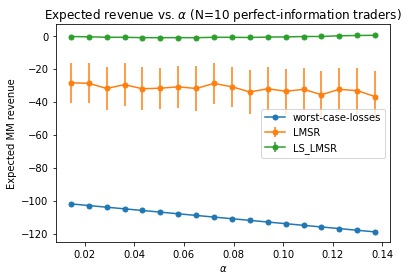

In [12]:
## Plot expected MM revenue vs alpha 
plt.plot(alphas, wcls, marker='o',markersize=5, label='worst-case-losses')
plt.errorbar(alphas, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
plt.errorbar(alphas, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
plt.ylabel('Expected MM revenue')
plt.title(r'Expected revenue vs. $\alpha$ (N=10 perfect-information traders)')
plt.xlabel(r'$\alpha$')
plt.legend()
# plt.savefig('figs/exprevenuevsalpha.png')
plt.show()

## Plot final MM revenue vs alpha 
# plt.errorbar(alphas, rev_LS, yerr=rev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
# plt.errorbar(alphas, rev_LMSR, yerr=rev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.plot(alphas, wcls, marker='o',markersize=5, label='worst-case-losses')
# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'Final MM revenue')
# plt.title(r'Revenue vs. $\alpha$ (N=10 perfect-information traders)')
# plt.legend()
# plt.savefig('figs/revenuevsalpha.png')
# plt.close()


## Miscellaneous plotting
# plt.scatter(acc_LS, rev_LS, label='LS-LMSR')
# plt.scatter(acc_LMSR, rev_LMSR, label='LMSR')

# plt.plot(alphas, acc_LS, marker='o',label='LS_LMSR')
# plt.plot(alphas, acc_LMSR, marker='o', label='LMSR')
# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'Final market prediction accuracy')
# plt.title(r'Market accuracy vs. $\alpha$ (N=10 perfect-information traders)')
# plt.legend()
# plt.savefig('figs/accuracyvsalpha.png')
# plt.close()

# print(alpha)

### Noisy information: run various simulations (different parameters) 

1. Run a simple noisy information simulation

In [13]:
s = Simulation()
ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
init_quant = [100, 100]
alpha = 0.03
markets = s.create_market_comp(init_quant, 'LMSR', 'LSLMSR', s.compute_b(alpha, init_quant)[0], alpha, ground_truth)
# b1_prob, b2_prob, b1_exprev, b2_exprev = s.noisyinfo_sim(10, 10000000, markets, silence=False, verbose=False)
b1_prob, b2_prob, b1_exprev, b2_exprev, _, _, _, _ = s.simple_noise_sim(10, 10000000, markets, verbose=True)
print()
print("LMSR price probabilities:", b1_prob)
print("LS-LMSR price probabilities:", b2_prob)
print("LMSR expected revenue:", b1_exprev)
print("LS-LMSR expected revenue:", b2_exprev)



GROUND TRUTH: [0.7479832347370632, 0.2520167652629368]
priv_info_noise: 0.2 ; look_back: 50 ; k: 0.5
INITIAL PRICE: LMSR [[0.5, 0.5]]
INITIAL PRICE: LS-LMSR [[0.5207944154167984, 0.5207944154167984]] 

LMSR market trader 0 :
Cost of transaction: 81.63214430696732
Expected final return after transaction: 95.2091071200923
Current price vs beliefs: [0.7095678936403937, 0.29043210635960626] [0.7092787396243634, 0.2907212603756366]
Final: bet: [134.23369657254267, 0.0] cost: 81.63214430696732
------
LS-LMSR market trader 0 :
Cost of transaction: 3.1856129509328355
Expected final return after transaction: 3.6328266969563834
Current price vs beliefs: [0.7152523282176582, 0.32155840628641796] [0.7092787396243634, 0.2907212603756366]
Final: bet: [5.121860411155622, 0.0] cost: 3.1856129509328355

LMSR market trader 1 :
Cost of transaction: 11.865967950757238
Expected final return after transaction: 12.038590147582374
Current price vs beliefs: [0.7316196319357725, 0.2683803680642275] [0.7311668

2. Run noisy information simulation: indep variable =  alpha 

In [14]:
vigs = np.arange(0.02, 0.4, 0.02)
alphas = vigs/(2*np.log(2))

N_TRADERS = 20
init_quant = [100, 100]
N_TRIALS = 40
LOOK_BACK = int(N_TRADERS/4)
K = 0.3
K_MIN = 0.2
K_MAX = 0.6
PRIV_NOISE = 0.2

acc_LS = []
acc_quartiles_LS = []
acc_LMSR = []
acc_quartiles_LMSR = []
exprev_LMSR = []
exprev_quartiles_LMSR = []
exprev_LS = []
exprev_quartiles_LS = []

wcls= [] # worst-case losses 

for alpha in alphas:
    s = Simulation()
    acc_LS_temp = []
    acc_LMSR_temp = []
    exprev_LMSR_temp = []
    exprev_LS_temp = []

    b, worst_case_loss = s.compute_b(alpha, init_quant)
    # print(b, worst_case_loss)
    wcls.append(-worst_case_loss)

    for i in range(N_TRIALS):
        #### SET HYPERPARAMETER
        ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
        #### 
        markets = s.create_market_comp([100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_prob, b2_prob, b1_exprev, b2_exprev, _, _, _, _ = s.simple_noise_sim(N_TRADERS, 10000000, markets, priv_info_noise=PRIV_NOISE,look_back=LOOK_BACK, k_min=K_MIN, k_max=K_MAX, silence=True, verbose=False)
        # b1_prob, b2_prob, b1_exprev, b2_exprev = s.noisyinfo_sim(N_TRADERS, 10000000, markets, p_signal_low=0.2, p_signal_high=0.8, silence=True, verbose=False)
        acc_LS_temp.append(1-abs(b2_prob[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_prob[0]-ground_truth[0]))
        exprev_LS_temp.append(b2_exprev)
        exprev_LMSR_temp.append(b1_exprev)
    
    acc_LMSR.append(np.median(acc_LMSR_temp))
    acc_LS.append(np.median(acc_LS_temp))
    exprev_LMSR.append(np.median(exprev_LMSR_temp))
    exprev_LS.append(np.median(exprev_LS_temp))
    acc_quartiles_LMSR.append([np.median(acc_LMSR_temp)-np.quantile(acc_LMSR_temp, 0.25), np.quantile(acc_LMSR_temp, 0.75)-np.median(acc_LMSR_temp)])
    acc_quartiles_LS.append([np.median(acc_LS_temp)-np.quantile(acc_LS_temp, 0.25), np.quantile(acc_LS_temp, 0.75)-np.median(acc_LS_temp)])
    exprev_quartiles_LMSR.append([np.median(exprev_LMSR_temp)-np.quantile(exprev_LMSR_temp, 0.25), np.quantile(exprev_LMSR_temp, 0.75)-np.median(exprev_LMSR_temp)])
    exprev_quartiles_LS.append([np.median(exprev_LS_temp)-np.quantile(exprev_LS_temp, 0.25), np.quantile(exprev_LS_temp, 0.75)-np.median(exprev_LS_temp)])
    
    print(acc_LMSR)
    print(acc_LS)
    
    # acc_LS.append(np.mean(acc_LS_temp))
    # acc_LMSR.append(np.mean(acc_LMSR_temp))
    # exprev_LMSR.append(np.mean(exprev_LMSR_temp))
    # exprev_stdevs_LMSR.append(np.std(exprev_LMSR_temp))
    # exprev_LS.append(np.mean(exprev_LS_temp))
    # exprev_stdevs_LS.append(np.std(exprev_LS_temp))

exprev_quartiles_LMSR = [[exprev_quartiles_LMSR[i][0] for i in range(len(alphas))], [exprev_quartiles_LMSR[i][1] for i in range(len(alphas))]] 
exprev_quartiles_LS = [[exprev_quartiles_LS[i][0] for i in range(len(alphas))], [exprev_quartiles_LS[i][1] for i in range(len(alphas))]] 
acc_quartiles_LMSR = [[acc_quartiles_LMSR[i][0] for i in range(len(alphas))], [acc_quartiles_LMSR[i][1] for i in range(len(alphas))]] 
acc_quartiles_LS = [[acc_quartiles_LS[i][0] for i in range(len(alphas))], [acc_quartiles_LS[i][1] for i in range(len(alphas))]] 

[0.9720603083890844]
[0.9629233940553725]
[0.9720603083890844, 0.9759140378247216]
[0.9629233940553725, 0.9711450805764843]
[0.9720603083890844, 0.9759140378247216, 0.9726596492959685]
[0.9629233940553725, 0.9711450805764843, 0.9630808126369262]
[0.9720603083890844, 0.9759140378247216, 0.9726596492959685, 0.9715290979421864]
[0.9629233940553725, 0.9711450805764843, 0.9630808126369262, 0.9553130283488382]
[0.9720603083890844, 0.9759140378247216, 0.9726596492959685, 0.9715290979421864, 0.9807302613163255]
[0.9629233940553725, 0.9711450805764843, 0.9630808126369262, 0.9553130283488382, 0.9522946308698799]
[0.9720603083890844, 0.9759140378247216, 0.9726596492959685, 0.9715290979421864, 0.9807302613163255, 0.9717303951991091]
[0.9629233940553725, 0.9711450805764843, 0.9630808126369262, 0.9553130283488382, 0.9522946308698799, 0.9379215071786162]
[0.9720603083890844, 0.9759140378247216, 0.9726596492959685, 0.9715290979421864, 0.9807302613163255, 0.9717303951991091, 0.9713263370185494]
[0.9629

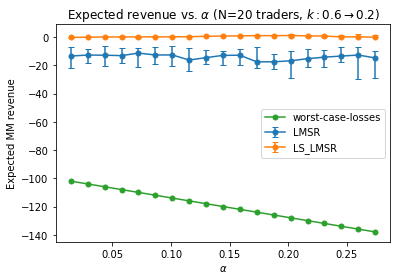

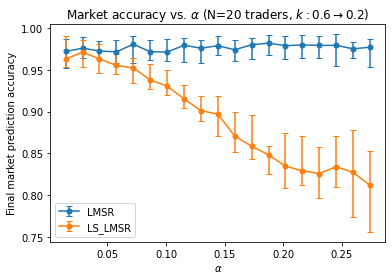

In [15]:
## Plot results

## A. EXP REV vs ALPHA 
# plt.errorbar(alphas, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.errorbar(alphas, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
## note: this plots MEDIANS and 1st / 3rd quartile
plt.errorbar(alphas, exprev_LMSR, yerr=exprev_quartiles_LMSR, marker='o',markersize=5, capsize=3, label='LMSR')
plt.errorbar(alphas, exprev_LS, yerr=exprev_quartiles_LS, marker='o',markersize=5, capsize=3, label='LS_LMSR')
plt.plot(alphas, wcls, marker='o',markersize=5, label='worst-case-losses')
plt.ylabel('Expected MM revenue')
plt.title(r'Expected revenue vs. $\alpha$ (N=20 traders, $k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'$\alpha$')
plt.legend()
# plt.savefig('figs/simple_noise_exprev_alpha.png')
plt.show()

## B. ACCURACY vs ALPHA 
# plt.plot(alphas, acc_LS, marker='o',label='LS_LMSR')
# plt.plot(alphas, acc_LMSR, marker='o', label='LMSR')
## note: this plots MEDIANS and 1st / 3rd quartile
plt.errorbar(alphas, acc_LMSR, yerr=acc_quartiles_LMSR, marker='o',markersize=5, capsize=3, label='LMSR')
plt.errorbar(alphas, acc_LS, yerr=acc_quartiles_LS, marker='o',markersize=5, capsize=3, label='LS_LMSR')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Final market prediction accuracy')
plt.title(r'Market accuracy vs. $\alpha$ (N=20 traders, $k: 0.6 \rightarrow 0.2$)')
plt.legend()
# plt.savefig('figs/simple_noise_acc_alpha.png')
plt.show()

## C. EXP REV vs ACCURACY (deprecated -- see Janum's code for plotting this instead)
# plt.plot(acc_LS, wcls, marker='o',markersize=5, label='worst-case-losses')
# plt.errorbar(acc_LMSR, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.errorbar(acc_LS, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
# plt.ylabel('Expected MM revenue')
# plt.title(r'Expected revenue vs. price accuracy (N=20 traders in noise model)')
# plt.xlabel(r'Price accuracy')
# plt.legend()
# # plt.savefig('figs/noise2_exprev_accuracy.png')
# plt.show()

3. Run noisy information simulation: indep variable =  number of traders 

In [16]:
N_TRAD_MAX = 30
n_traders_arr = np.arange(1, N_TRAD_MAX)
init_quant = [100, 100]
alpha = 0.03
N_TRIALS = 40
LOOK_BACK = int(N_TRAD_MAX/4)
K = 0.3
K_MIN = 0.2
K_MAX = 0.6
PRIV_NOISE = 0.2

acc_LS = []
acc_LS_med = []
acc_quartiles_LS = []
acc_stdevs_LS = []

acc_LMSR = []
acc_LMSR_med = []
acc_quartiles_LMSR = []
acc_stdevs_LMSR = []

exprev_LS = []
exprev_LS_med = []
exprev_stdevs_LS = []

for nt in n_traders_arr:
    s = Simulation()
    b, worst_case_loss = s.compute_b(alpha, init_quant)
    acc_LS_temp = []
    acc_LMSR_temp = []
    exprev_LS_temp = []

    for i in range(N_TRIALS):
        #### SET HYPERPARAMETERS
        ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
        #### 
        markets = s.create_market_comp([100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_prob, b2_prob, b1_exprev, b2_exprev, _, _, _, _ = s.simple_noise_sim(nt, 10000000, markets, priv_info_noise=PRIV_NOISE,look_back=LOOK_BACK, k_min=K_MIN, k_max=K_MAX, silence=True, verbose=False)
        # b1_prob, b2_prob, b1_exprev, b2_exprev, _, _, _, _ = s.simple_noise_sim(nt, 10000000, markets, priv_info_noise=0.2,look_back=LOOK_BACK,k=K, silence=True, verbose=False)
        # b1_prob, b2_prob, b1_exprev, b2_exprev, _, _, _, _ = s.noisyinfo_sim(nt, 10000000, markets, priv_info_noise=0.3, p_signal_low=0.1, p_signal_high=0.9, silence=True, verbose=False)

        acc_LS_temp.append(1-abs(b2_prob[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_prob[0]-ground_truth[0]))
        exprev_LS_temp.append(b2_exprev)

    acc_LS.append(np.mean(acc_LS_temp))
    acc_LS_med.append(np.median(acc_LS_temp))
    acc_stdevs_LS.append(np.std(acc_LS_temp))
    acc_quartiles_LS.append([np.median(acc_LS_temp)-np.quantile(acc_LS_temp, 0.25), np.quantile(acc_LS_temp, 0.75)-np.median(acc_LS_temp)])

    acc_LMSR.append(np.mean(acc_LMSR_temp))
    acc_LMSR_med.append(np.median(acc_LMSR_temp))
    acc_stdevs_LMSR.append(np.std(acc_LMSR_temp))
    acc_quartiles_LMSR.append([np.median(acc_LMSR_temp)-np.quantile(acc_LMSR_temp, 0.25), np.quantile(acc_LMSR_temp, 0.75)-np.median(acc_LMSR_temp)])

    exprev_LS.append(np.mean(exprev_LS_temp))
    exprev_LS_med.append(np.median(exprev_LS_temp))
    exprev_stdevs_LS.append(np.std(exprev_LS_temp))

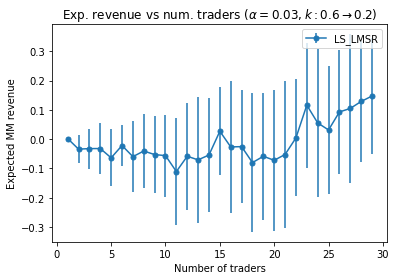

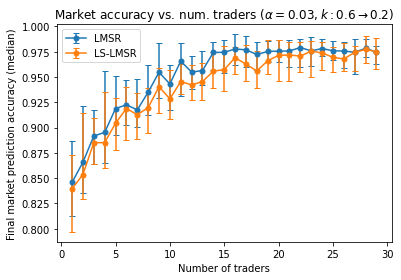

In [17]:
## Plot results

# 1. EXP REV vs NT 
plt.errorbar(n_traders_arr, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
plt.ylabel('Expected MM revenue')
plt.title(r'Exp. revenue vs num. traders ($\alpha=0.03,k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'Number of traders')
plt.legend()
# plt.savefig('figs/simple_noise_nt_exprev.png')
plt.show()

# 2. ACC vs NT
# note: this plots MEDIANS and QUANTILES
acc_quartiles_LMSR = [[acc_quartiles_LMSR[i][0] for i in range(len(n_traders_arr))], [acc_quartiles_LMSR[i][1] for i in range(len(n_traders_arr))]] 
acc_quartiles_LS = [[acc_quartiles_LS[i][0] for i in range(len(n_traders_arr))], [acc_quartiles_LS[i][1] for i in range(len(n_traders_arr))]] 
# plt.errorbar(n_traders_arr, acc_LS, yerr=acc_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
# plt.errorbar(n_traders_arr, acc_LMSR, yerr=acc_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
plt.errorbar(n_traders_arr, acc_LMSR_med, yerr=acc_quartiles_LMSR, marker='o', markersize=5, capsize=3, label='LMSR')
plt.errorbar(n_traders_arr, acc_LS_med, yerr=acc_quartiles_LS, marker='o', markersize=5, capsize=3, label='LS-LMSR')
plt.ylabel('Final market prediction accuracy (median)')
plt.title(r'Market accuracy vs. num. traders ($\alpha=0.03,k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'Number of traders')
plt.legend()
# plt.savefig('figs/simple_noise_nt_acc.png')
plt.show()

In [52]:
init_quant = [100, 100]
N_TRIALS = 100
N_TRADERS = 10
wcls = []
K_MIN = 0.2
K_MAX = 0.6

# Set hyperparams
alpha = 0.03
p = 0.1

acc_LS_temp = []
acc_LMSR_temp = []
rev_LS_temp = []
rev_LMSR_temp = []
exprev_LMSR_temp = []
exprev_LS_temp = []
o1, o2 = [], []

for i in range(N_TRIALS):
    s = Simulation()
    b, worst_case_loss = s.compute_b(alpha, init_quant)
    # b = 150.27
    ground_truth = s.draw_unif_ground_truth(p, p+0.1)
    ####
    markets = s.create_market_comp(
        [100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
    b1, b2 = markets[0], markets[1]
    b1_prob, b2_prob, b1_exprev, b2_exprev, b1_rev, b2_rev, out1, out2 = s.simple_noise_sim(
        10, 10000000, markets, silence=True, verbose=False)

    acc_LS_temp.append(1-abs(b2_prob[0]-ground_truth[0]))
    acc_LMSR_temp.append(1-abs(b1_prob[0]-ground_truth[0]))
    rev_LS_temp.append(b2_rev)
    rev_LMSR_temp.append(b1_rev)
    exprev_LS_temp.append(b2_exprev)
    exprev_LMSR_temp.append(b1_exprev)
    o1.append(out1)
    o2.append(out2)

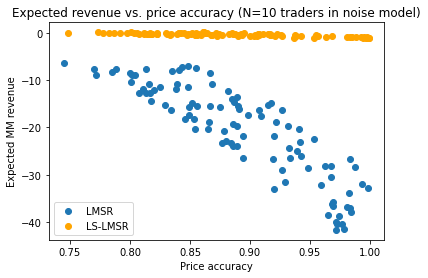

In [53]:
# Plot Expected Revenue vs Accuracy for LMSR, LS-LMSR

plt.scatter(acc_LMSR_temp, exprev_LMSR_temp)
plt.scatter(acc_LS_temp, exprev_LS_temp, c='orange' if p ==
            0.1 else 'yellow', label="test2")
plt.ylabel('Expected MM revenue')
plt.title(r'Expected revenue vs. price accuracy (N=10 traders in noise model)')
plt.xlabel(r'Price accuracy')
plt.legend(["LMSR", "LS-LMSR"], loc="lower left")

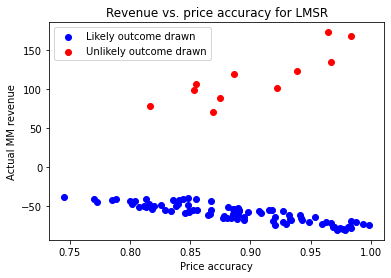

In [57]:
# Plot Actual Revenue vs Accuracy for LMSR
o1 = np.array(o1)
idx1, idx2 = np.where(o1!=0)[0], np.where(o1==0)[0]
plt.scatter(np.array(acc_LMSR_temp)[idx1], np.array(rev_LMSR_temp)[idx1], c="blue")
plt.scatter(np.array(acc_LMSR_temp)[idx2], np.array(rev_LMSR_temp)[idx2], c="red")
plt.ylabel('Actual MM revenue')
plt.title(r'Revenue vs. price accuracy for LMSR (N=10 traders in noise model)')
plt.xlabel(r'Price accuracy')
plt.legend(["Likely outcome drawn", "Unlikely outcome drawn"])
plt.show()

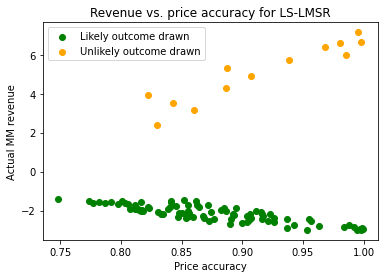

In [56]:
# Plot Actual Revenue vs Accuracy for LS-LMSR
o2 = np.array(o2)
idx1, idx2 = np.where(o2!=0)[0], np.where(o2==0)[0]
plt.scatter(np.array(acc_LS_temp)[idx1], np.array(rev_LS_temp)[idx1], c="green")
plt.scatter(np.array(acc_LS_temp)[idx2], np.array(rev_LS_temp)[idx2], c="orange")
plt.ylabel('Actual MM revenue')
plt.title(r'Revenue vs. price accuracy for LS-LMSR (N=10 traders in noise model)')
plt.xlabel(r'Price accuracy')
plt.legend(["Likely outcome drawn", "Unlikely outcome drawn"])
plt.show()